In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, SpatialDropout2D, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
# Constants
IMG_SIZE = 224  # Standard size for many pre-trained models
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 15
CLASSES = ['Hi', 'No', 'Ok', 'Talk', 'You']
NUM_CLASSES = len(CLASSES)

In [5]:
# Function to load and preprocess images
def load_dataset(dataset_path, img_size=IMG_SIZE):
    """
    Load images from the dataset directory and preprocess them
    """
    images = []
    labels = []
    
    print(f"Loading dataset from: {dataset_path}")
    
    # Iterate through each class folder
    for idx, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.exists(class_path):
            print(f"Warning: Path not found for class '{class_name}': {class_path}")
            continue
            
        print(f"Processing class: {class_name} (index: {idx})")
        
        # Iterate through images in the class folder
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                
                try:
                    # Read and preprocess image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    img = cv2.resize(img, (img_size, img_size))
                    
                    # Normalize pixel values to [0,1]
                    img = img / 255.0
                    
                    images.append(img)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

In [6]:
# Function to visualize training history
def plot_training_history(history):
    """
    Plot training and validation accuracy/loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [7]:
# Function to visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix for model evaluation
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [8]:
# Function to display sample images from the dataset
def display_sample_images(images, labels, class_names, num_samples=5):
    """
    Display sample images from each class
    """
    plt.figure(figsize=(15, len(class_names)*2))
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == i)[0]
        
        if len(class_indices) == 0:
            continue
            
        samples = min(num_samples, len(class_indices))
        
        for j in range(samples):
            if j < len(class_indices):
                idx = class_indices[j]
                plt.subplot(len(class_names), num_samples, i*num_samples + j + 1)
                plt.imshow(images[idx])
                plt.title(f"{class_name}")
                plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

In [9]:
# Data augmentation function
def create_data_generators(X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE):
    """
    Create data generators with augmentation for training
    """
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # No augmentation for validation
    val_datagen = ImageDataGenerator()
    
    # Create generators
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_generator = val_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_generator, val_generator

In [10]:
# Custom CNN model
def create_custom_cnn_model(input_shape, num_classes):
    """
    Create a custom CNN model with advanced architecture
    """
    model = Sequential([
        # First convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        # Second convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Third convolutional block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        # Fourth convolutional block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        # Fully connected layers
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model


In [11]:
# Transfer learning with EfficientNet
def create_efficientnet_model(input_shape, num_classes):
    """
    Create a model using EfficientNetB0 with transfer learning
    """
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom layers on top
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model, base_model

In [12]:
# Transfer learning with ResNet50V2
def create_resnet_model(input_shape, num_classes):
    """
    Create a model using ResNet50V2 with transfer learning
    """
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom layers on top
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model, base_model

# Transfer learning with MobileNetV2
def create_mobilenet_model(input_shape, num_classes):
    """
    Create a model using MobileNetV2 with transfer learning
    """
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom layers on top
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model, base_model

In [13]:
# Function to unfreeze layers for fine-tuning
def unfreeze_model(model, base_model, num_layers_to_unfreeze=10):
    """
    Unfreeze the last few layers of the base model for fine-tuning
    """
    # Unfreeze the base model
    base_model.trainable = True
    
    # Freeze all the layers except the last num_layers_to_unfreeze
    for layer in base_model.layers[:-num_layers_to_unfreeze]:
        layer.trainable = False
    
    # Compile the model with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [14]:
# Main execution function
def main():
    """
    Main function to execute the full pipeline
    """
    print("Starting Hand Gesture Recognition System")
    
    # 1. Load dataset
    try:
        print("Loading dataset...")
        X, y = load_dataset("dataset")
        
        if len(X) == 0:
            raise ValueError("No images were loaded. Check the dataset path.")
        
        print(f"Dataset loaded successfully: {len(X)} images with shape {X.shape}")
        
        # Display sample images
        display_sample_images(X, y, CLASSES)
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    
    # 2. Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
    
    print(f"Dataset split: Train={X_train.shape}, Validation={X_val.shape}, Test={X_test.shape}")
    
    # 3. Convert labels to categorical
    y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
    y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
    y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
    
    # 4. Create data generators
    train_generator, val_generator = create_data_generators(X_train, y_train_cat, X_val, y_val_cat)
    
    # 5. Create and train models
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        'best_hand_gesture_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    callbacks = [checkpoint, early_stopping, reduce_lr]
    
    # Train models
    models_to_train = {
        "Custom CNN": create_custom_cnn_model(input_shape, NUM_CLASSES),
        "EfficientNetB0": create_efficientnet_model(input_shape, NUM_CLASSES)[0],
        "ResNet50V2": create_resnet_model(input_shape, NUM_CLASSES)[0],
        "MobileNetV2": create_mobilenet_model(input_shape, NUM_CLASSES)[0]
    }
    
    best_model = None
    best_accuracy = 0
    
    for model_name, model in models_to_train.items():
        print(f"\nTraining {model_name}...")
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Model summary
        model.summary()
        
        # Train model
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plot_training_history(history)
        
        # Evaluate on test set
        test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
        print(f"{model_name} - Test accuracy: {test_acc:.4f}")
        
        # Save model with name
        model.save(f'hand_gesture_{model_name.lower().replace(" ", "_")}_model.h5')
        
        # Keep track of best model
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = model
            best_model_name = model_name
    
    print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")
    
    # 6. Fine-tune the best model if it's a transfer learning model
    if best_model_name != "Custom CNN":
        print("\nFine-tuning the best model...")
        
        # Recreate the model for fine-tuning
        if best_model_name == "EfficientNetB0":
            model, base_model = create_efficientnet_model(input_shape, NUM_CLASSES)
        elif best_model_name == "ResNet50V2":
            model, base_model = create_resnet_model(input_shape, NUM_CLASSES)
        elif best_model_name == "MobileNetV2":
            model, base_model = create_mobilenet_model(input_shape, NUM_CLASSES)
        
        # Load weights from the best model
        model.load_weights(f'hand_gesture_{best_model_name.lower().replace(" ", "_")}_model.h5')
        
        # Unfreeze layers for fine-tuning
        model = unfreeze_model(model, base_model)
        
        # Fine-tune the model
        history_ft = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=30,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot fine-tuning history
        plot_training_history(history_ft)
        
        # Evaluate fine-tuned model
        test_loss_ft, test_acc_ft = model.evaluate(X_test, y_test_cat, verbose=1)
        print(f"Fine-tuned {best_model_name} - Test accuracy: {test_acc_ft:.4f}")
        
        # Save fine-tuned model
        model.save(f'hand_gesture_{best_model_name.lower().replace(" ", "_")}_finetuned_model.h5')
        
        # Update best model if fine-tuning improved it
        if test_acc_ft > best_accuracy:
            best_accuracy = test_acc_ft
            best_model = model
            print(f"Fine-tuning improved the best model. New accuracy: {best_accuracy:.4f}")
    
    # 7. Final evaluation on test set
    print("\nFinal evaluation on test set...")
    y_pred = np.argmax(best_model.predict(X_test), axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    
    # Confusion matrix
    plot_confusion_matrix(y_true, y_pred, CLASSES)
    
    # 8. Save the final best model
    best_model.save('hand_gesture_best_model.h5')
    print("\nTraining completed successfully!")
    
    # 9. Create a simple real-time prediction script
    create_realtime_prediction_script()
    
    print("\nA real-time prediction script has been created: 'hand_gesture_realtime.py'")

Starting Hand Gesture Recognition System
Loading dataset...
Loading dataset from: dataset
Processing class: Hi (index: 0)
Processing class: No (index: 1)
Processing class: Ok (index: 2)
Processing class: Talk (index: 3)
Processing class: You (index: 4)
Dataset loaded successfully: 50 images with shape (50, 224, 224, 3)


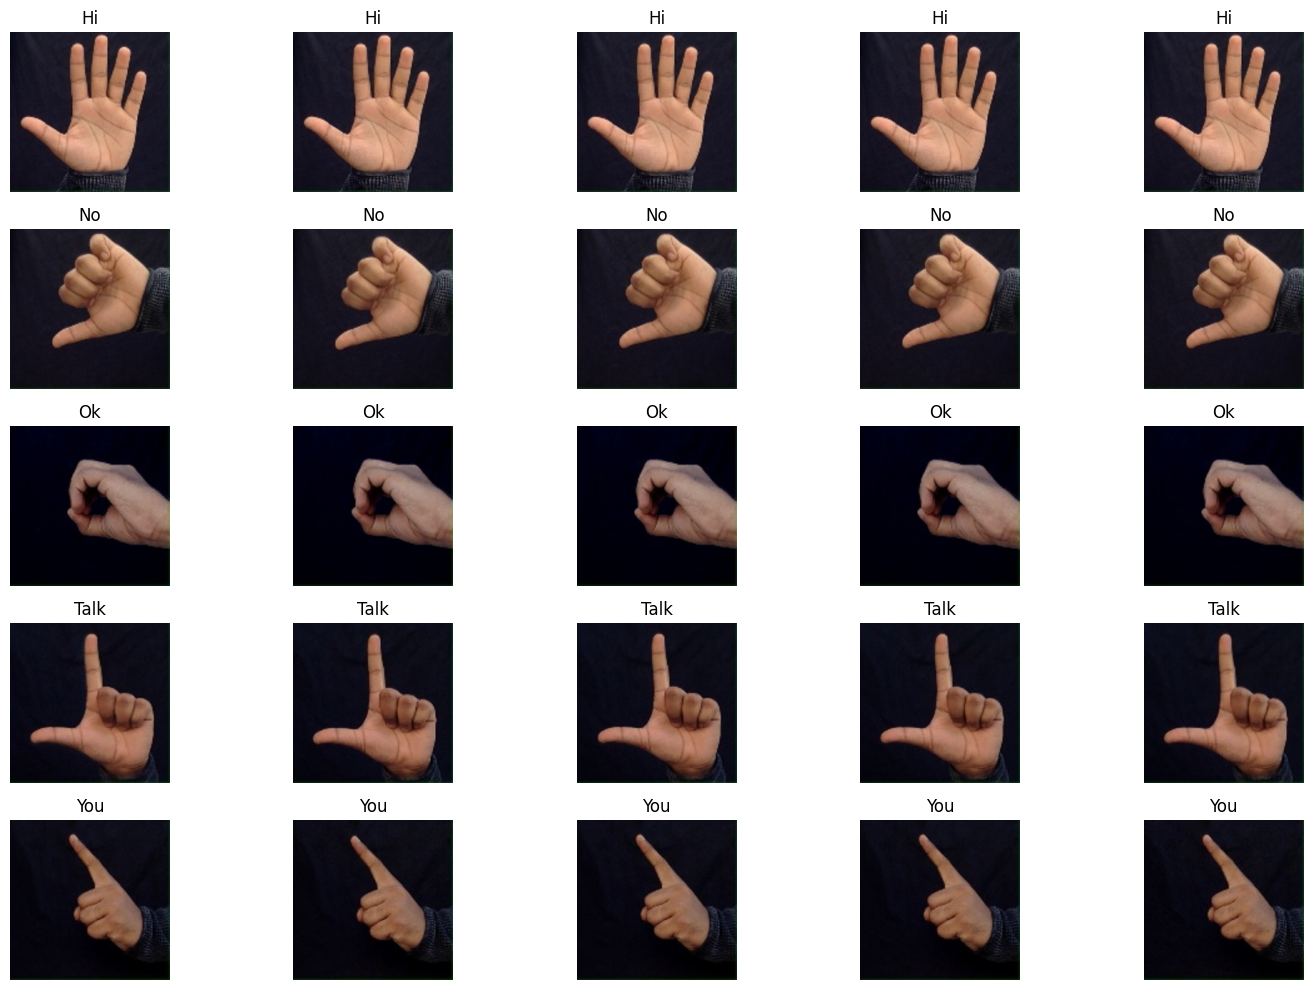

Dataset split: Train=(40, 224, 224, 3), Validation=(5, 224, 224, 3), Test=(5, 224, 224, 3)



Training Custom CNN...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)  

c:\Users\Sivap\Documents\Hand_Sign_Model\Hand_Sign_Model\.venv_new\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 24s 18s/step - loss: 2.1097 - accuracy: 0.3000 - val_loss: 1.6238 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.7250 
Epoch 2: val_accuracy did not improve from 0.20000
2/2 [==============================] - 43s 6s/step - loss: 0.7498 - accuracy: 0.7250 - val_loss: 1.9979 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.8250
Epoch 3: val_accuracy did not improve from 0.20000
2/2 [==============================] - 16s 12s/step - loss: 0.6035 - accuracy: 0.8250 - val_loss: 2.5930 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.8750
Epoch 4: val_accuracy did not improve from 0.20000
2/2 [==============================] - 15s 12s/step - loss: 0.5054 - accuracy: 0.8750 - val_loss: 2.8263 - val_accuracy: 0.2000 - lr: 0.0010
Epoc

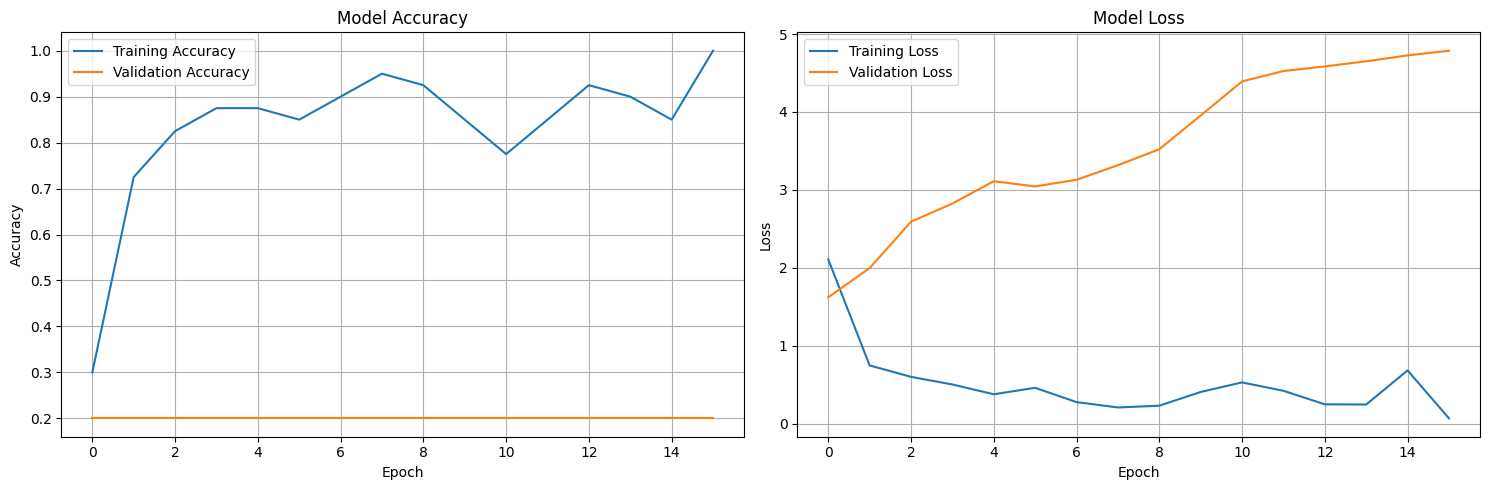

1/1 [==============================] - 1s 667ms/step - loss: 1.6238 - accuracy: 0.2000
Custom CNN - Test accuracy: 0.2000

Training EfficientNetB0...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_10 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                           

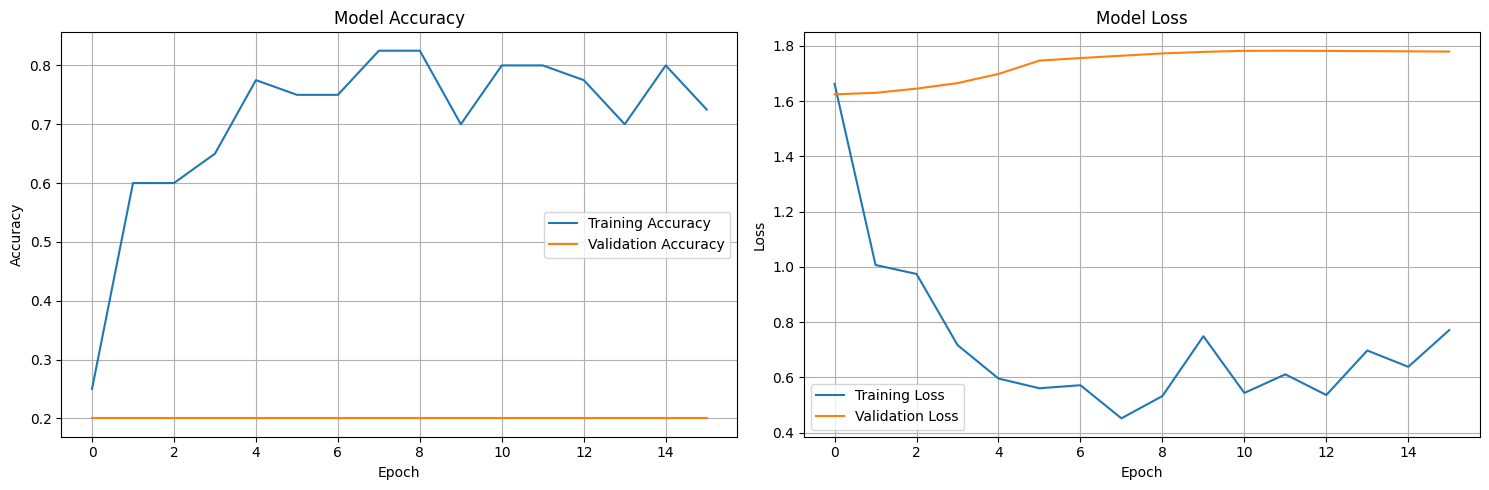

1/1 [==============================] - 0s 120ms/step - loss: 1.6248 - accuracy: 0.2000
EfficientNetB0 - Test accuracy: 0.2000

Training ResNet50V2...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_12 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dropout_8 (Dropout)         (None, 2048)

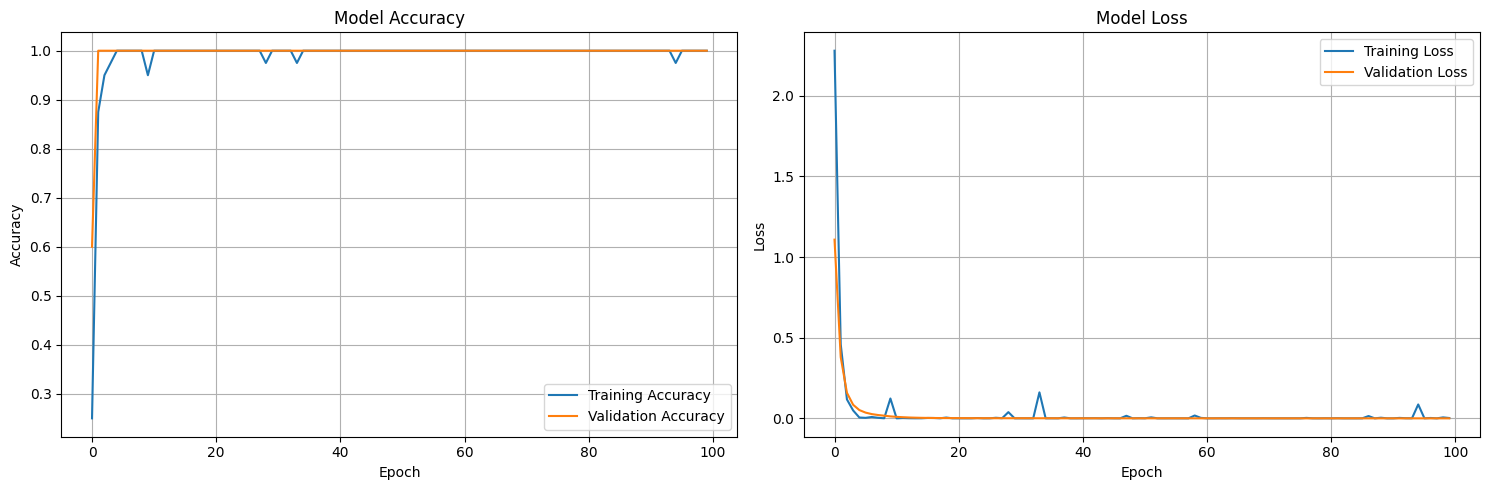

1/1 [==============================] - 0s 235ms/step - loss: 2.7918e-05 - accuracy: 1.0000
ResNet50V2 - Test accuracy: 1.0000

Training MobileNetV2...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_14 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                        

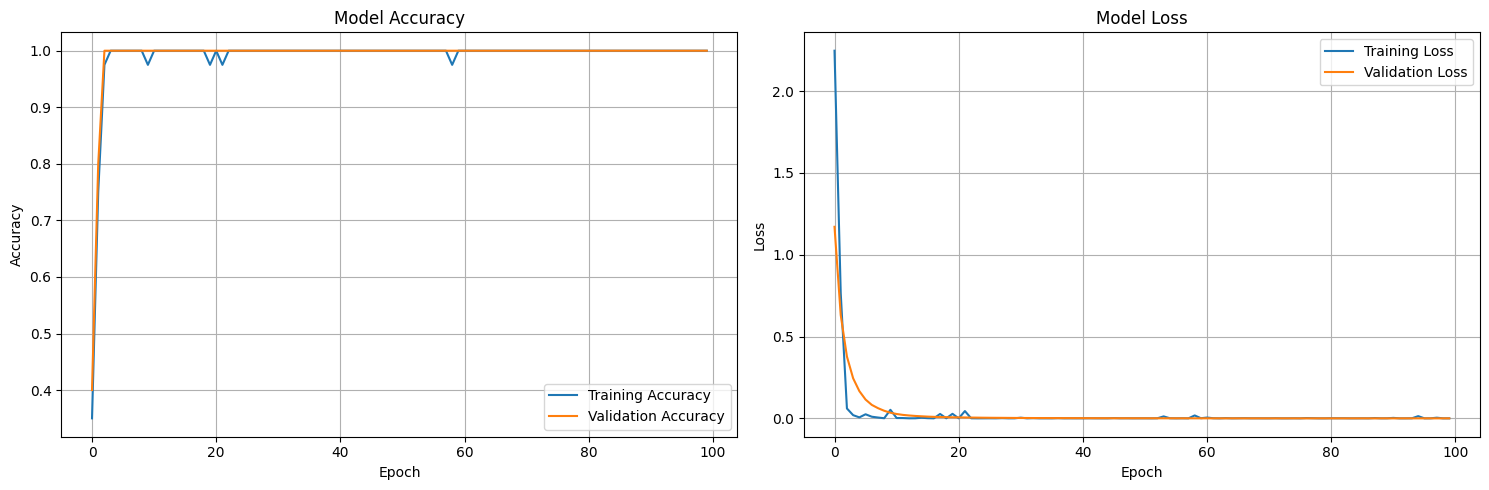

1/1 [==============================] - 0s 77ms/step - loss: 2.6655e-05 - accuracy: 1.0000
MobileNetV2 - Test accuracy: 1.0000

Best model: ResNet50V2 with accuracy: 1.0000

Fine-tuning the best model...
Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
2/2 [==============================] - 6s 3s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 3.0135e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 1.0023e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
2/2 [==============================] - 3s 777ms/step - loss: 1.0023e-04 - accuracy: 1.0000 - val_loss: 2.9920e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 1.6447e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
2/2 [==============================] - 2s 2s/step - loss: 1

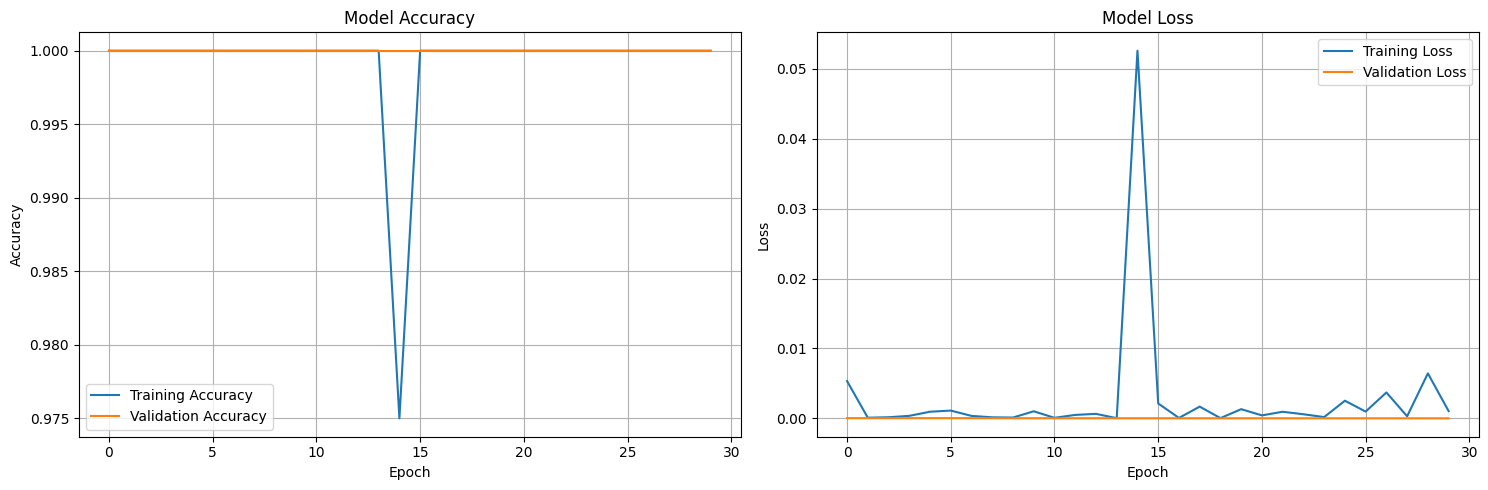

1/1 [==============================] - 0s 261ms/step - loss: 5.8174e-06 - accuracy: 1.0000
Fine-tuned ResNet50V2 - Test accuracy: 1.0000

Final evaluation on test set...
1/1 [==============================] - 2s 2s/step

Classification Report:
              precision    recall  f1-score   support

          Hi       1.00      1.00      1.00         1
          No       1.00      1.00      1.00         1
          Ok       1.00      1.00      1.00         1
        Talk       1.00      1.00      1.00         1
         You       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



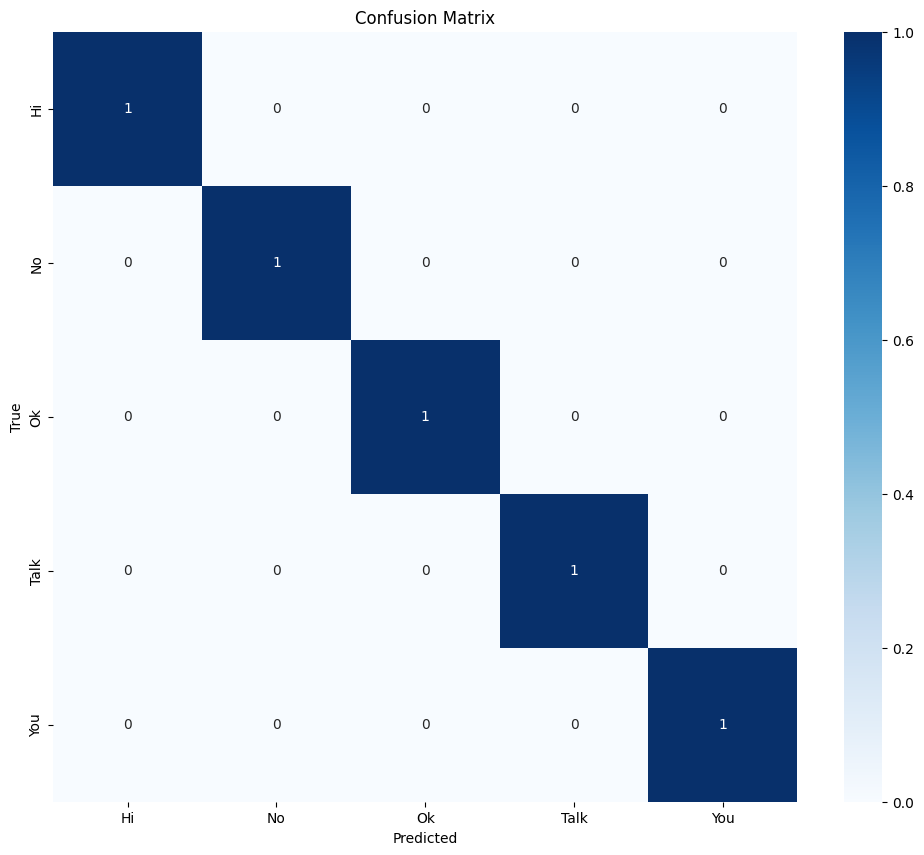

c:\Users\Sivap\Documents\Hand_Sign_Model\Hand_Sign_Model\.venv_new\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Training completed successfully!

A real-time prediction script has been created: 'hand_gesture_realtime.py'


In [15]:
def create_realtime_prediction_script():
    """
    Create a script for real-time hand gesture recognition using webcam
    """
    script_content = """
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = 224
CLASSES = ['Hi', 'No', 'Ok', 'Talk', 'You']

# Load the model
model = load_model('hand_gesture_best_model.h5')
print("Model loaded successfully!")

# Initialize webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

# Define ROI coordinates (you can adjust these)
roi_top, roi_right, roi_bottom, roi_left = 100, 350, 300, 550

# Text settings
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (0, 255, 0)
line_type = 2

while True:
    # Read frame from webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break
    
    # Flip frame horizontally for selfie-view
    frame = cv2.flip(frame, 1)
    
    # Draw ROI rectangle
    cv2.rectangle(frame, (roi_left, roi_top), (roi_right, roi_bottom), (0, 255, 0), 2)
    
    # Extract ROI
    roi = frame[roi_top:roi_bottom, roi_left:roi_right]
    
    # Preprocess ROI for prediction
    try:
        roi_resized = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
        roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
        roi_normalized = roi_rgb / 255.0
        roi_input = np.expand_dims(roi_normalized, axis=0)
        
        # Make prediction
        prediction = model.predict(roi_input)
        predicted_class_idx = np.argmax(prediction[0])
        predicted_class = CLASSES[predicted_class_idx]
        confidence = prediction[0][predicted_class_idx] * 100
        
        # Draw prediction and confidence on frame
        text = f"{predicted_class}: {confidence:.2f}%"
        cv2.putText(frame, text, (30, 50), font, font_scale, font_color, line_type)
        
    except Exception as e:
        print(f"Error in prediction: {e}")
    
    # Display frame
    cv2.imshow('Hand Gesture Recognition', frame)
    
    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
"""
    
    with open('hand_gesture_realtime.py', 'w') as f:
        f.write(script_content)

if __name__ == "__main__":
    main()